In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from einops import rearrange
import sys,sqlite3,glob,pickle,copy,json
from scipy.stats import spearmanr,pearsonr

In [2]:
import escreen

# Load Data

In [3]:
class SequenceDataset(Dataset):
    def __init__(self, df, ct_dict, x_col_name='one hot', y_col_name='label', z_col_name='cell_type', max_len=500):
        self.df = df
        self.ct_dict = ct_dict
        self.x_col_name = x_col_name
        self.y_col_name = y_col_name
        self.z_col_name = z_col_name
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        seq = self.df.iloc[idx][self.x_col_name][:self.max_len]
        target = self.df.iloc[idx][self.y_col_name]
        celltype = self.df.iloc[idx][self.z_col_name]
        x = torch.tensor(np.stack(seq), dtype=torch.float)
        y = torch.tensor(float(target), dtype=torch.float)
        z = torch.tensor(self.ct_dict[celltype],dtype=torch.long)
        return x, y, z

In [6]:
import pickle
with open('../data/celltype.dict','rb') as file:
    cell_type_dict = json.load(file)

with open('../data/K562_demo_dataset.pkl','rb') as file:
    K562_Demo_Dataset = pickle.load(file)
    
trainset = K562_Demo_Dataset['Trainset']
testset  = K562_Demo_Dataset['Testset']
validset = K562_Demo_Dataset['Validset']

train_ds = SequenceDataset(trainset, cell_type_dict)
test_ds  = SequenceDataset(testset , cell_type_dict)
valid_ds = SequenceDataset(validset, cell_type_dict)

train_loader = DataLoader(train_ds , batch_size=16)
test_loader  = DataLoader(test_ds  , batch_size=16)
valid_loader = DataLoader(valid_ds , batch_size=16)

## Train

In [10]:
motifs_f, motifs_r, motif_names, motif_length = escreen.motif_tool.load_pwm_from_meme_c(
    "/cluster2/huanglab/liquan/motif/consensus_pwms.meme", max_length=35
)
seed = 114514
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # 禁用cudnn非确定性算法
torch.backends.cudnn.benchmark = False     # 关闭自动寻找最优卷积算法
kernel_fwd  = torch.tensor(motifs_f,dtype=torch.float)
kernel_rev  = torch.tensor(motifs_r,dtype=torch.float)
d_in = None
d_model = 512
num_filters = 512

model = escreen.eScreen(
    kernel_fwd = kernel_fwd,kernel_rev = kernel_rev,d_model=d_model,
    num_filters=num_filters,seq_length=500,celltype_num=32,lr=1e-5,device='cuda:1',
)

In [ ]:
torch.cuda.empty_cache()
model.fit(train_loader,test_loader,epochs=10,lr=1e-4,check_step=500,earlystop=20,device='cuda:0',save_name='./K562_model')

## Prediction & Evaluation

In [6]:
motifs_f, motifs_r, motif_names, motif_length = escreen.motif_tool.load_pwm_from_meme_c(
    "/cluster2/huanglab/liquan/motif/consensus_pwms.meme", max_length=35
)
seed = 114514
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # 禁用cudnn非确定性算法
torch.backends.cudnn.benchmark = False     # 关闭自动寻找最优卷积算法
kernel_fwd  = torch.tensor(motifs_f,dtype=torch.float)
kernel_rev  = torch.tensor(motifs_r,dtype=torch.float)
d_in = None
d_model = 512
num_filters = 512

model = escreen.eScreen(
    kernel_fwd = kernel_fwd,kernel_rev = kernel_rev,d_model=d_model,
    num_filters=num_filters,seq_length=500,celltype_num=32,lr=1e-5,device='cuda:0',
)

model.load_state_dict( torch.load('./K562_model.best.pt',map_location='cuda:0') )

<All keys matched successfully>

In [10]:
p,y = model.predict(valid_loader,device='cuda:0',verbose=True,with_true=True)
print( round(spearmanr(p,y)[0],4),round(pearsonr(p,y)[0],4) )

100%|██████████| 230/230 [00:07<00:00, 30.83it/s]

0.6879 0.7076


AUC: 0.8972
MCC: 0.6559
F1 Score: 0.8294
Accuracy: 0.8279
Recall: 0.8243
Precision: 0.8346


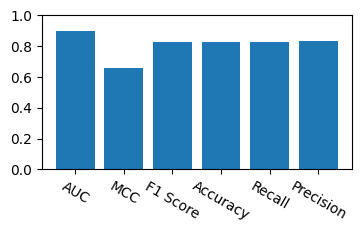

In [20]:
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

predictions = p;labels = y
predicted_labels = [1 if p >= 0.5 else 0 for p in predictions]

# 计算指标
auc_val = auc(roc_curve(labels, predictions)[0],roc_curve(labels, predictions)[1])
mcc = matthews_corrcoef(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
accuracy = accuracy_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)

# 输出结果
print(f"AUC: {auc_val:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plt.figure(figsize=(4,2))
plt.bar([1,2,3,4,5,6],[auc_val,mcc,f1,accuracy,recall,precision])
plt.ylim([0,1])
plt.xticks([1,2,3,4,5,6],["AUC","MCC","F1 Score","Accuracy","Recall","Precision"],rotation=-30)
plt.show()

In [52]:
with open('./data/TilingCase.pkl','rb') as file:
    globin_case = pickle.load(file)

with open('./data/celltype.dict','r') as file:
    cell_type_dict = json.load(file)
    
globin_case_ds = SequenceDataset(globin_case, cell_type_dict)
globin_case_loader = DataLoader(globin_case_ds , batch_size=16)

In [54]:
p,y = model.predict(globin_case_loader,device='cuda:1',verbose=True,with_true=True)
globin_case['prediction'] = p

100%|██████████| 4/4 [00:00<00:00, 36.13it/s]


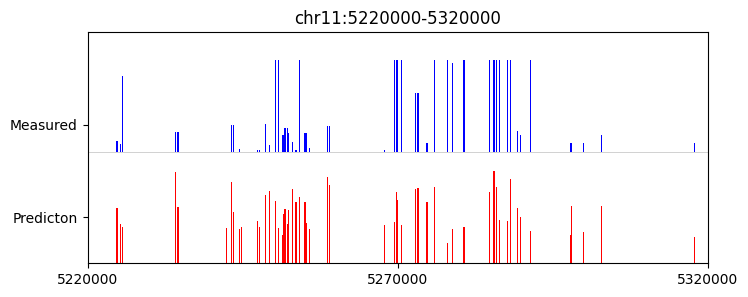

In [57]:
import matplotlib.pyplot as plt
from matplotlib import patches

plt.figure(figsize=(8,3))
plt.plot([5220000,5320000],[1.2,1.2],color='grey',alpha=0.5,linewidth=0.5)

ax = plt.gca()

for rw in ALLCRE.itertuples():
    rect = patches.Rectangle( (rw.start+150,0.0),width=200,height=rw.prediction/ALLCRE['prediction'].max(),
                             edgecolor=None,facecolor='r',alpha=1.0,linewidth=1.5 )
    ax.add_patch(rect)        
    rect = patches.Rectangle( (rw.start+150,1.2),width=200,height=np.clip(rw.RRA,0,4)/4,
                             edgecolor=None,facecolor='b',alpha=1.0,linewidth=1.5 )
    ax.add_patch(rect)

plt.xlim([5220000,5320000])
plt.xticks([5220000,5270000,5320000],['5220000','5270000','5320000'])
plt.ylim([0.0,2.5])
plt.yticks([0.5,1.5],['Predicton','Measured'])
plt.title('chr11:5220000-5320000')
plt.show()